In [13]:
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [14]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

In [15]:
import keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from IPython.display import clear_output
from plot_losses import PlotLosses

## Keras modules

In [16]:
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint 
from keras.models import Sequential
from keras.layers.core import Dense, Flatten
from keras.layers import Conv2D, AveragePooling2D

## Cargo datos

In [17]:
folder = '../input/fashion-mnist-itba-lab-ml-2018b/'
!ls {folder}

test_images.npy  train_images.npy train_labels.csv


In [18]:
x = np.load(folder + 'train_images.npy')
y = np.loadtxt(folder + 'train_labels.csv', delimiter=',', skiprows=1)
x_test = np.load(folder + 'test_images.npy')

## Lo llevo a formato de imágenes de 28 x 28 x 1

In [19]:
x = np.expand_dims(x, axis=3)
x.shape

(60000, 28, 28, 1)

In [20]:
x_test = np.expand_dims(x_test, axis=3)
x_test.shape

(10000, 28, 28, 1)

In [21]:
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size = 0.1)

## Paso a float

In [22]:
x_train = x_train.astype('float32')
x_valid = x_valid.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_valid /= 255
x_test /= 255

In [23]:
y_train_categorical = to_categorical(y_train)
y_val_categorical = to_categorical(y_valid)

## Red neuronal: CNN LeNet-5

In [24]:
model = Sequential()

model.add(Conv2D(filters=6, kernel_size=(5, 5), activation='tanh', input_shape=(28,28,1), padding='same'))

model.add(AveragePooling2D())

model.add(Conv2D(filters=16, kernel_size=(5, 5), activation='tanh'))

model.add(AveragePooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(units=120, activation='tanh'))

model.add(Dense(units=84, activation='tanh'))

model.add(Dense(units=10, activation = 'softmax'))

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 28, 28, 6)         156       
_________________________________________________________________
average_pooling2d_3 (Average (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
average_pooling2d_4 (Average (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 120)               48120     
_________________________________________________________________
dense_5 (Dense)              (None, 84)                10164     
__________

In [25]:
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [26]:
# Callbacks
## Callback para graficar
plot_losses = PlotLosses(plot_interval=1, evaluate_interval=20, x_val=x_valid, y_val_categorical=y_val_categorical)
## Callback para guardar pesos
checkpointer = ModelCheckpoint(filepath='checkpoint.mnist-cnn.hdf5', verbose=1, save_best_only=True)

In [27]:
x_train.shape

(54000, 28, 28, 1)

In [28]:
y_train_categorical.shape

(54000, 10)

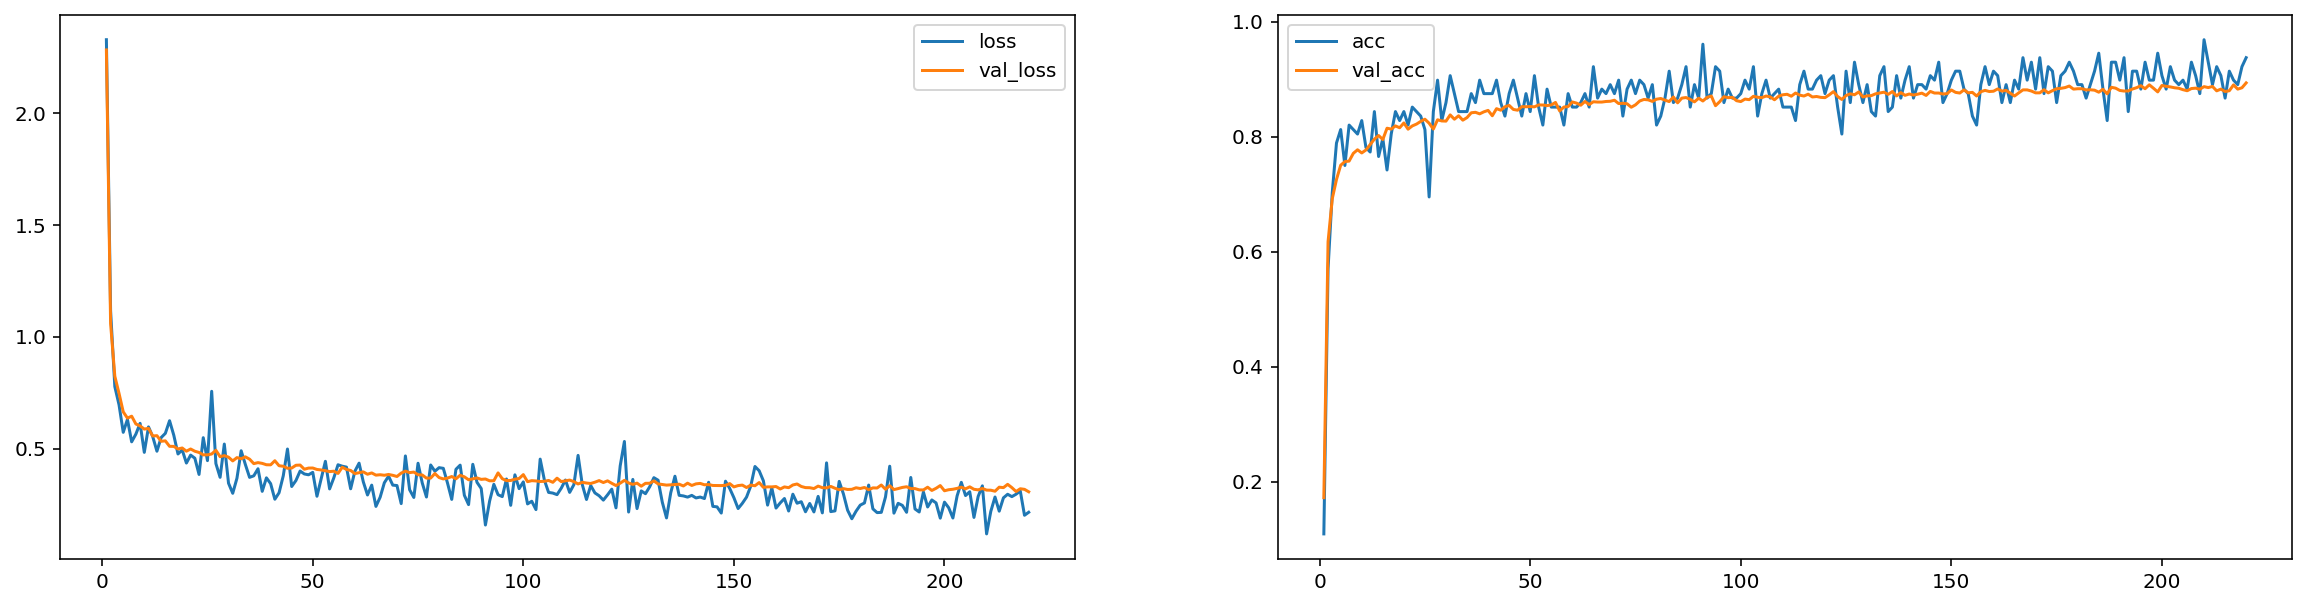


Epoch 00010: val_loss improved from 0.31958 to 0.30768, saving model to checkpoint.mnist-cnn.hdf5


In [29]:
batch_size = 128
epocs = 10

model.fit(x_train, 
        y_train_categorical,
        epochs=epocs, batch_size=batch_size, 
        verbose=1, 
        validation_data = (x_valid, y_val_categorical),
        callbacks=[plot_losses, checkpointer],
    )

In [31]:
model.load_weights('checkpoint.mnist-cnn.hdf5')

In [32]:
loss, acc = model.evaluate(x_valid, y_val_categorical)

6000/6000 [==============================] - 3s 509us/step


In [33]:
print(acc)

0.892


In [37]:
test_prediction = model.predict(x_test)

In [38]:
test_labels = np.argmax(test_prediction, axis = 1)

In [39]:
import pandas as pd
df = pd.DataFrame(data={"Category": test_labels}).astype(int)
df.to_csv("./submission.csv", sep=',',index=True,  index_label='Id')